In [65]:
%pip install davos
import davos

%conda install pytables

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [66]:
smuggle nltools as nlt            # pip: nltools==0.4.7

smuggle nilearn as nl             # pip: nilearn==0.10.0
smuggle nibabel as nib            # pip: nibabel==5.0.1

smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.colors smuggle ListedColormap, hex2color, rgb2hex
from matplotlib.ticker smuggle FormatStrFormatter
from matplotlib.lines import Line2D
smuggle matplotlib
from matplotlib smuggle rc

smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from skimage smuggle transform    # pip: scikit-image==0.20.0

from sklearn.decomposition smuggle IncrementalPCA as PCA  # pip: scikit-learn==1.2.1
from scipy.spatial.distance smuggle cdist                 # pip: scipy==1.10.1
from scipy.io smuggle loadmat
from scipy.stats smuggle spearmanr, pearsonr
from tqdm smuggle tqdm            # pip: tqdm==4.64.1
smuggle jinja2 as j2              # pip: jinja2==3.1.2
smuggle networkx as nx            # pip: networkx==3.0

from sklearn.linear_model smuggle LinearRegression        # pip: scikit-learn==1.2.1

smuggle requests                  # pip: requests==2.28.2

from datetime import datetime as dt
import os
import shutil
import pickle
import warnings
from glob import glob as lsdir

from helpers import nii2cmu, cmu2nii, conditions, condition_colors, figdir, basedir, datadir, scratch_dir, group_pca, get_data, rbf

Fetch/load the HTFA posterior

In [67]:
data = get_data()

Load a neurosynth topic map to use as a template

In [68]:
neurosynth_dir = os.path.join(datadir, 'neurosynth')
nii_fname = os.path.join(neurosynth_dir, 'topic0_pFgA_z.nii.gz')
template = nii2cmu(nii_fname)

Compute the HTFA factor images matrix:
  - Rows: factors
  - Columns: voxels in the template brain

In [69]:
factors = []
for c, w in zip(data['centers'], data['widths']):
    factors.append(np.atleast_2d(rbf(template['R'], c, w)).T)

F = np.hstack(factors).T

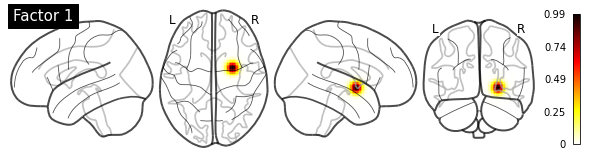

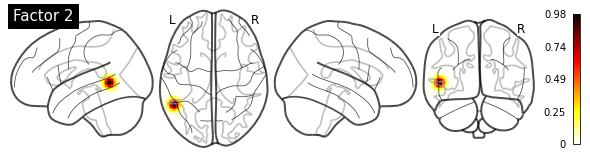

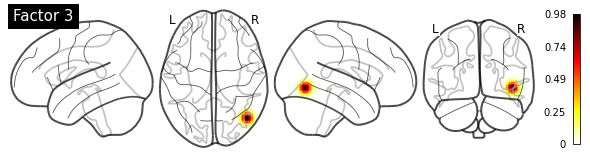

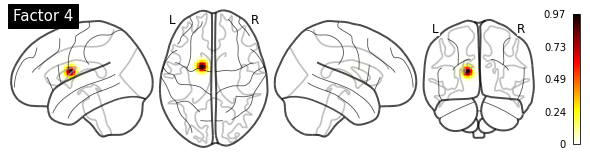

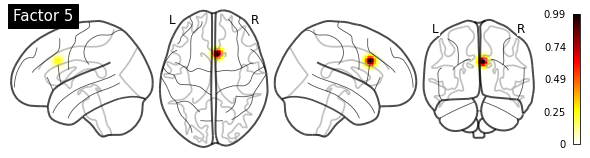

In [70]:
# plot some sample factors

for i in range(5):
    nl.plotting.plot_glass_brain(cmu2nii(F[i, :], template['R'], nii_fname), colorbar=True, title=f'Factor {i+1}', display_mode='lzry', figure=plt.figure(figsize=(8, 2)))

Compress each condition using group PCA

In [71]:
# number of components to plot/decode
k = 5

components = {}
for c in conditions:
    _, model = group_pca(data['weights'][c], n_components=k)
    X = model.components_
    components[c] = [cmu2nii(np.dot(np.atleast_2d(X[i, :]), F), template['R'], nii_fname) for i in range(k)]

# Figures 5C and S3 

Plot the component images

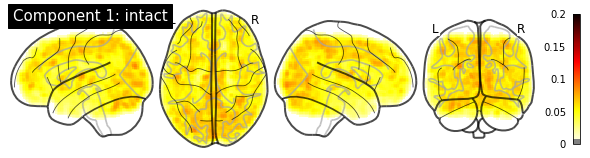

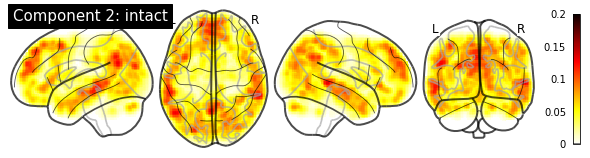

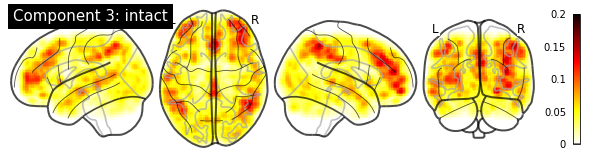

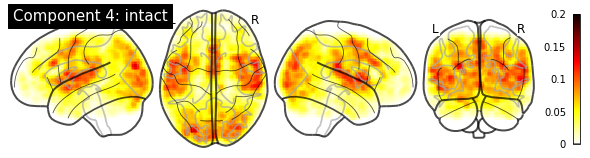

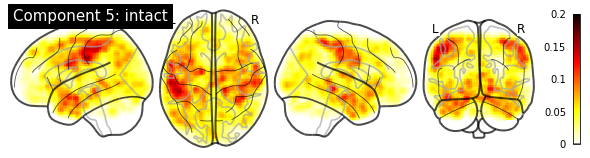

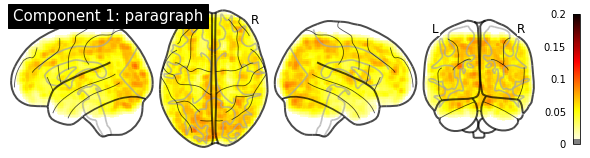

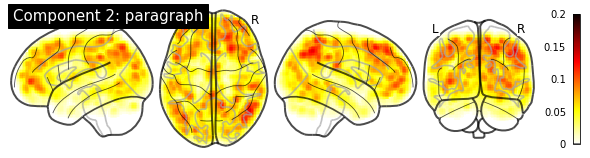

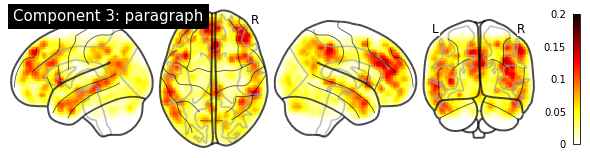

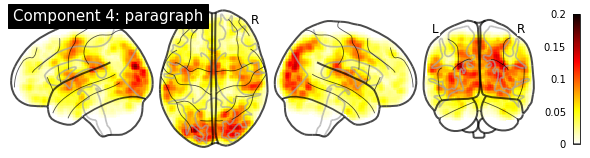

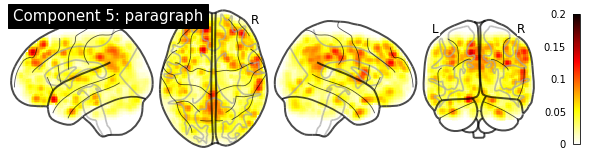

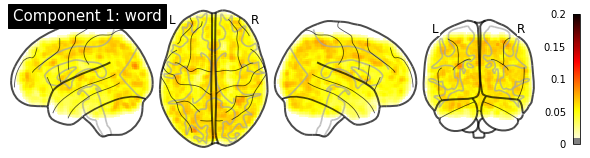

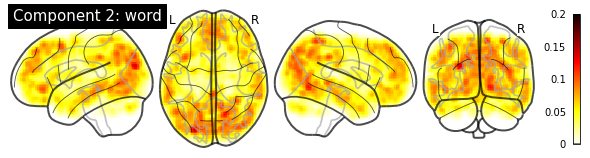

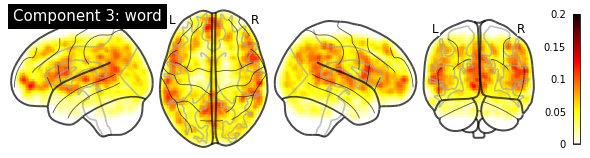

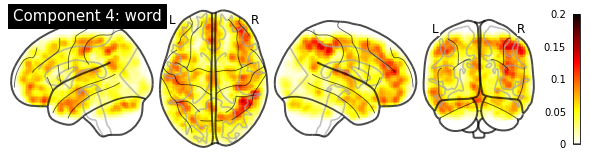

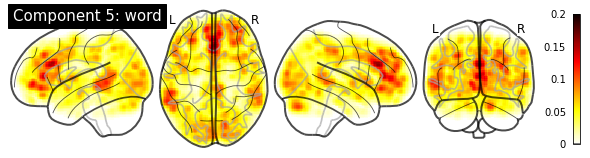

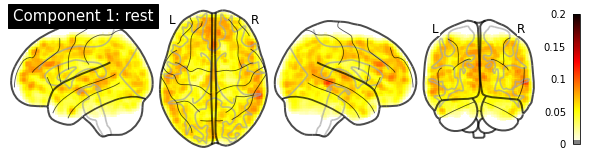

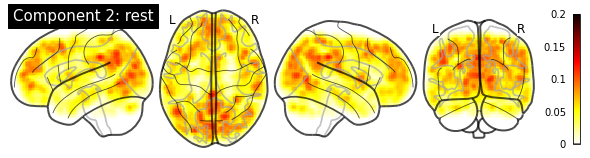

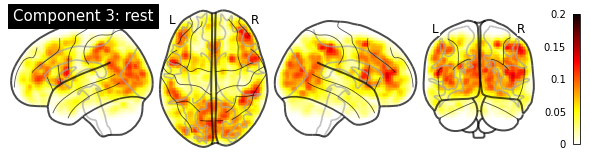

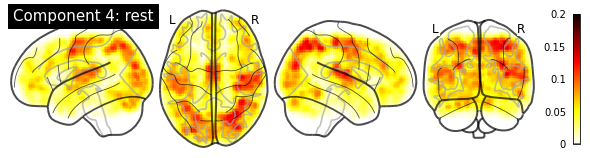

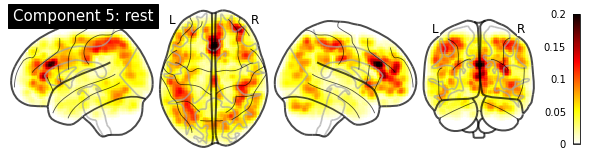

In [72]:
for c in conditions:
    for i in range(k):
        # plot the full component
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, vmin=0, vmax=0.2, display_mode='lzry', figure=plt.figure(figsize=(8, 2)), output_file=os.path.join(figdir, f'component_{c}_{i+1}_full.pdf'))

        # plot a compact view of the component
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, vmin=0, vmax=0.2, display_mode='r', figure=plt.figure(figsize=(4, 2)), output_file=os.path.join(figdir, f'component_{c}_{i+1}_sagittal_r.pdf'))

        # display the component (with title) in the notebook
        nl.plotting.plot_glass_brain(components[c][i], colorbar=True, vmin=0, vmax=0.2, title=f'Component {i+1}: {c}', display_mode='lzry', figure=plt.figure(figsize=(8, 2)))

# Table S1

In [73]:
topics = pd.read_csv(os.path.join(neurosynth_dir, 'topics.csv')).drop('Topic Number', axis=1).drop(['Manual Label', 'Mean doc. weight'], axis=1).rename({'ChatGPT Label': 'Topic Label'}, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter('ignore') # ignore depreciation warning about exporting to latex
    topics.iloc[:, :12].to_latex(os.path.join(figdir, 'neurosynth_topics.tex'), index=False, column_format='r' + 'l' * (len(topics.columns) - 11))
topics

Topic Label      Cognitive Label  \
0              Cognitive control and task performance    Cognitive control   
1                  Developmental aging and maturation                    -   
2                  Eye movements and visual attention            Attention   
3                        Facial and voice recognition   Sensory perception   
4          Social interaction and contextual behavior     Social cognition   
..                                                ...                  ...   
75                     Speech and language processing  Language processing   
76  Network interactions and evidence in human sys...                    -   
77                            Neuroimaging techniques                    -   
78               Visual perception of motion and form   Sensory perception   
79                Emotional processing and regulation              Emotion   

         Term 1    Term 2      Term 3       Term 4       Term 5  \
0         tasks   control     network   conditions   comparison   
1           age    adults    children  development  adolescents   
2           eye      gaze        eyes       visual     saccades   
3   recognition  familiar    identity   unfamiliar        voice   
4       context      game       human  interaction          ppi   
..          ...       ...         ...          ...          ...   
75       speech  language    auditory   production   perception   
76      network  evidence       human      systems      support   
77     standard    images  individual         time        image   
78       motion    visual  perception   perceptual   biological   
79    emotional   emotion     neutral       facial  expressions   

           Term 6         Term 7       Term 8  ...      Term 11      Term 12  \
0       performed         common   correlates  ...       active     relative   
1           aging  developmental  adolescence  ...         aged   maturation   
2       movements        saccade    direction  ...     fixation       guided   
3     familiarity          route       voices  ...          atl       famous   
4      contextual       contexts       agency  ...  cooperation     behavior   
..            ...            ...          ...  ...          ...          ...   
75  comprehension      listening     acoustic  ...       sounds       native   
76        process       distinct  integration  ...         role  distributed   
77          voxel        spatial         test  ...  sensitivity          spm   
78        dynamic         moving        human  ...     stimulus         psts   
79      affective      responses     negative  ...     pictures      fearful   

                Term 13     Term 14         Term 15      Term 16      Term 17  \
0            underlying    distinct      substrates    cognitive   performing   
1             adulthood     elderly         reduced   adolescent         ages   
2               pursuit  oculomotor        movement      walking     saccadic   
3                person       names      perception       people   expression   
4   psychophysiological         avh           trust     partners       played   
..                  ...         ...             ...          ...          ...   
75           bilinguals      spoken        speakers    languages     prosodic   
76           perceptual      domain         current   underlying  interaction   
77                space         roi        measures      provide  reliability   
78            direction   sensitive  discrimination         cues         form   
79                happy        fear         disgust  emotionally   perception   

           Term 18         Term 19    Term 20  
0          process           shown   addition  
1             late      developing      range  
2          control          closed     direct  
3   discrimination      personally  condition  
4         computer         virtual     online  
..             ...             ...        ...  
75           voice        phon

### Neurosynth decoding

References:

1. Fox AS, Chang LJ, Gorgolewski KJ, Yarkoni T (2014) [Bridging psychology and genetics using large-scale spatial analysis of neuroimaging and neurogenetic data](https://www.biorxiv.org/content/10.1101/012310v1.abstract).  bioRxiv: doi.org/10.1101/012310

2. Sul S, Güroğlu B, Crone EA, Chang LJ (2017) [Medial prefrontal cortical thinning mediates shifts in other-regarding preferences during adolescence](https://www.nature.com/articles/s41598-017-08692-6.epdf?shared_access_token=axJA9l5exJBRRof-RbTwv9RgN0jAjWel9jnR3ZoTv0N5WG5h1jAaEDJCl6rCzAwqd-CrMFv4PhRKQOqdWcanXG1L9xI9ib0fpcZhug9nV9o7YHzsZYGg3z7ryrmh_WnnAsc0F9znsZb5nvUtDHpgoorMLCs8C0l4JJLYHDy4IV0%3D).  Scientific Reports, 7(8510): doi.org/10.1038/s41598-017-08692-6

3. Chen P-HA, Jolly E, Cheong JH, Chang LJ (2020) [Intersubject representational similarity analysis reveals individual
variations in affective experience when watching erotic movies](http://cosanlab.com/static/papers/Chen_2020_Neuroimage.pdf).  NeuroImage, 216(116851): doi.org/10.1016/j.neuroimage.2020.116851

Load in topic maps

In [74]:
topic_maps = [nii2cmu(os.path.join(neurosynth_dir, f'topic{i}_pFgA_z.nii.gz')) for i in topics.index.values]

Display some example maps

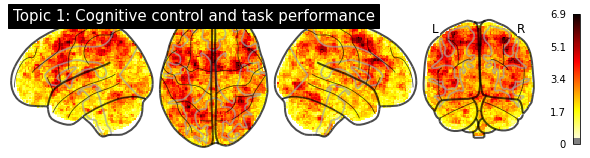

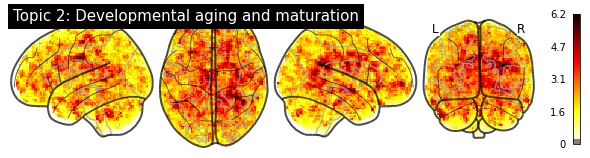

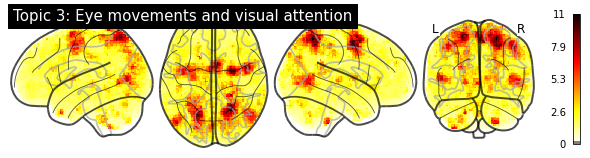

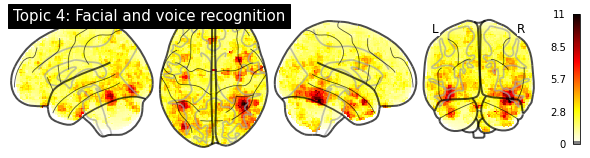

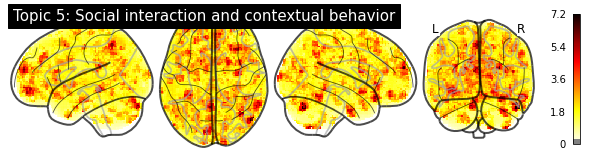

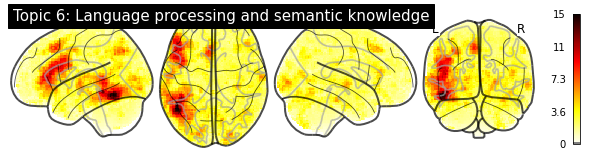

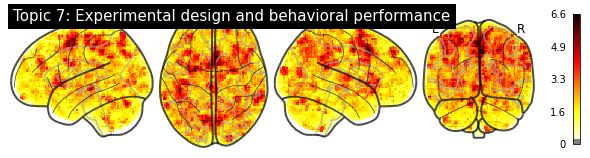

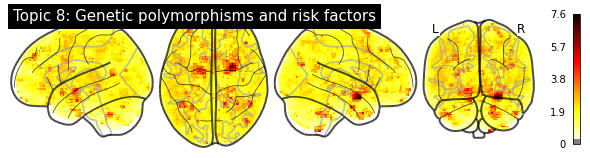

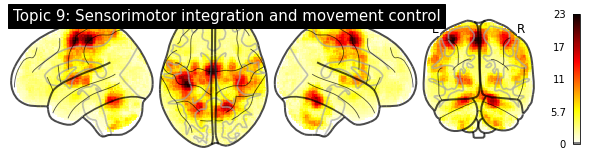

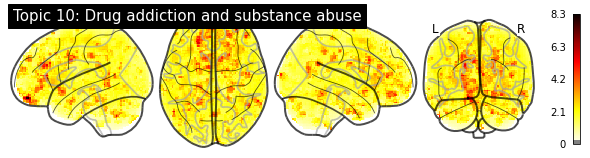

In [75]:
for i, topic in enumerate(topics.index.values[:10]):
    nl.plotting.plot_glass_brain(cmu2nii(topic_maps[i]['Y'], template['R'], nii_fname), colorbar=True, title=f'Topic {topic+1}: {topics.loc[topic]["Topic Label"]}', display_mode='lzry', figure=plt.figure(figsize=(8, 2)))

Convert component maps to CMU format

In [76]:
cmu_components = {}
for c in conditions:
    cmu_components[c] = [nii2cmu(x) for x in components[c]]

Use decoding procedure from [Sul et al. (2017)](https://www.nature.com/articles/s41598-017-08692-6.epdf?shared_access_token=axJA9l5exJBRRof-RbTwv9RgN0jAjWel9jnR3ZoTv0N5WG5h1jAaEDJCl6rCzAwqd-CrMFv4PhRKQOqdWcanXG1L9xI9ib0fpcZhug9nV9o7YHzsZYGg3z7ryrmh_WnnAsc0F9znsZb5nvUtDHpgoorMLCs8C0l4JJLYHDy4IV0%3D) to estimate topic weights from maps for each component and condition

In [77]:
def topic_weights(Y):
    x = np.array([np.corrcoef(topic_maps[i]['Y'], Y)[0, 1] for i in range(len(topic_maps))])
    return x
    

In [78]:
df = []
for c in conditions:
    for i in tqdm(range(k)):
        weights = topic_weights(cmu_components[c][i]['Y'])

        for j in range(len(topic_maps)):
            x = pd.Series(dtype=object)
            x['Condition'] = c
            x['Component'] = i+1
            x['Topic'] = topics.iloc[j]['Topic Label']
            x['Weight'] = weights[j]
            df.append(pd.DataFrame(x).T)

df = pd.concat(df, ignore_index=True)
df['Weight'] = df['Weight'].astype(float)

100%|██████████| 5/5 [00:00<00:00,  8.97it/s]


In [79]:
def sort_df(df, reference, value_column, target_column, ascending=False, return_order=False):
    # sort rows by weight order in intact condition for component 1
    x = df.copy()
    for k, v in reference.items():
        x = x[x[k] == v]

    order = x.sort_values(value_column, ascending=ascending)[target_column].values
    order_key = {order[i]: i for i in range(len(order))}

    x = df.copy()
    x['Sort Order'] = x[target_column].apply(lambda i: order_key[i])
    x = x.sort_values([*list(reference.keys()), 'Sort Order'])
    x = x.drop('Sort Order', axis=1)

    if return_order:
        return x, order
    return x

In [80]:
df, topic_order = sort_df(df, {'Condition': 'intact', 'Component': 1}, 'Weight', 'Topic', ascending=False, return_order=True)

In [81]:
def create_legend(colors, labels, text_colors=None, marker='o', width=6, height=2.25, ncol=3, fname=None):
    fig = plt.figure(figsize=(width, height))
    ax = plt.subplot(111)

    if marker is not None:
        legend_elements = [Line2D([0], [0], marker=marker, color='w', label=l, markerfacecolor=c, markersize=10) for l, c in zip(labels, colors)]
        ax.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.3, 1.1), fontsize=10, ncol=ncol, frameon=False)
    else:
        if text_colors is None:
            text_colors = colors

        legend_properties = {'weight':'bold'}
        legend_elements = [Line2D([0], [0], marker=marker, color='w', label=l, markerfacecolor=w, markersize=1) for l, _ in zip(labels, colors)]
        ax.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.3, 1.1), fontsize=10, ncol=ncol, frameon=False, prop=legend_properties)

    if text_colors is not None:    
        legend = ax.get_legend()
        for i, text in enumerate(legend.get_texts()):
            text.set_color(text_colors[i])
    
    ax.axis('off')
    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    return fig

In [82]:
def mix_colors(a, b, mu):
    if type(a) == str:
        a = hex2color(a)
    a = np.array(a)
    if type(b) == str:
        b = hex2color(b)
    b = np.array(b)

    return rgb2hex((1-mu) * a + mu * b)

In [83]:
def get_color_gradient(start_color, end_color, n, extra=False):
    if extra:
        n += 1
    colors = [mix_colors(start_color, end_color, i / (n - 1)) for i in range(n)]
    if extra:
        colors = colors[:-1]
    return colors

# Legend used in Figures 5 and S4

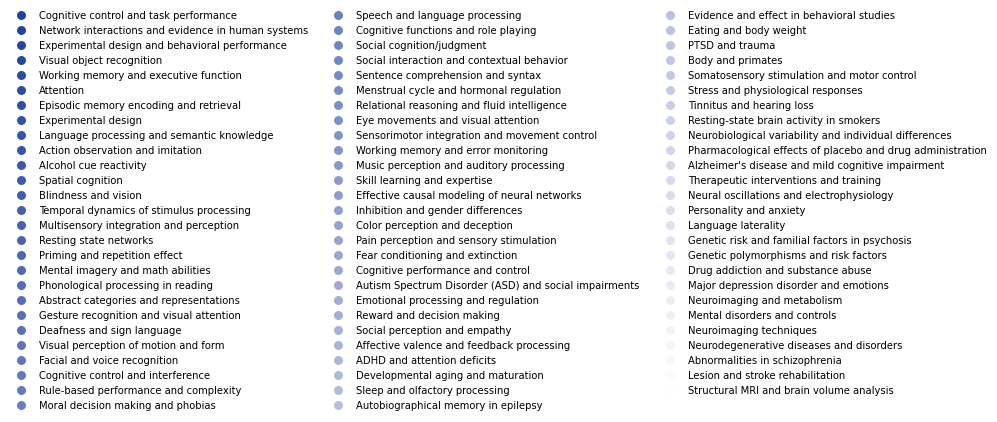

In [84]:
create_legend(get_color_gradient(condition_colors['intact'], '#ffffff', topics.shape[0] + 1)[:-1], topic_order, fname='topic_legend');

In [85]:
def format(s, target=10):
    s = str(s).split()
    y = []
    next = ''
    appended = False
    for i in range(len(s)):
        if len(next) + len(s[i]) + 1 > target:
            y.append(next)
            next = s[i]
        else:
            next += ' ' + s[i]
    
    if next != '':
        y.append(next)
    
    return '\n'.join(y)

In [86]:
def spider_plot(x, xcol, ycol, hue=None, limit=None, tick_labels=None, tick_colors=None, axfontsize=10, tick_fontsize_scale=1, ax=None, colors=None, alpha=0.1, legend=False, pad=0, width=5, height=5, fname=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(width, height))
        ax = plt.subplot(111, polar=True)

    if limit is not None:
        if hue is not None:
            keep_vals = x.groupby(hue).apply(lambda x: x.nlargest(limit, ycol)).reset_index(drop=True)[xcol].unique()
            x = x[x[xcol].isin(keep_vals)]
        else:
            x = x.nlargest(limit, ycol)

    unique_xvals = x[xcol].unique()
    unique_yvals = x[ycol].unique()

    angles = [n / float(len(unique_xvals)) * 2 * np.pi for n in range(len(unique_xvals))]
    angles += angles[:1]

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])

    

    ax.set_rlabel_position(90)    
    #ax.set_yticks([np.min(unique_yvals), np.max(unique_yvals)])
    #ax.set_yticklabels([np.min(unique_yvals), np.max(unique_yvals)], fontsize=axfontsize)

    if hue is not None:
        unique_hues = x[hue].unique()
        if colors is None:    
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                colors = get_cmap('viridis', len(unique_hues))
                colors = [colors(i) for i in range(len(unique_hues))]
        elif type(colors) == dict:
            colors = [colors[h] for h in unique_hues]

        for i, h in enumerate(unique_hues):
            xh = x[x[hue] == h]

            next_angles = [angles[np.where(unique_xvals == v)[0][0]] for v in xh[xcol].values.tolist()]
            order = np.argsort(next_angles)
            
            next_angles = np.array(next_angles)[order].tolist()
            next_angles += next_angles[:1]

            values = xh[ycol].values[order].tolist()
            values += values[:1]
            ax.fill(next_angles, values, alpha=alpha, color=colors[i])
            ax.plot(next_angles, values, linestyle='solid', linewidth=1, label=h, color=colors[i], **kwargs)
        
        if legend:
            ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=axfontsize)
    else:
        if colors is None:
            colors = ['k']        
        elif type(colors) == str:
            colors = [colors]            
        values = x[ycol].values.tolist()
        values += values[:1]
        ax.plot(angles, values, linestyle='solid', color=colors[0], **kwargs)

    ax.set_yticks(ax.get_yticks()[:-2:2])
    ax.tick_params(axis='both', which='major', labelsize=axfontsize)

    if tick_labels is None:
        ax.set_xticklabels([format(s) for s in unique_xvals], fontsize=axfontsize * tick_fontsize_scale)
    else:
        ax.set_xticklabels(tick_labels, fontsize=axfontsize * tick_fontsize_scale)

    if tick_colors is not None:        
        [t.set_color(c) for t, c in zip(ax.get_xticklabels(), tick_colors)]    
    ax.tick_params(axis='x', pad=pad)
    [t.set_horizontalalignment('center') for t in ax.get_xticklabels()]

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

# Figure 5A

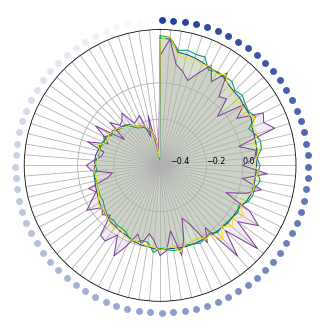

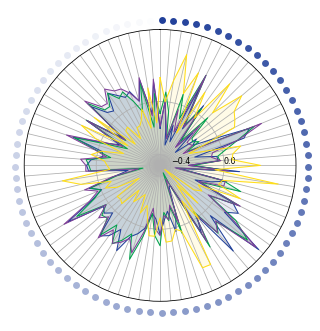

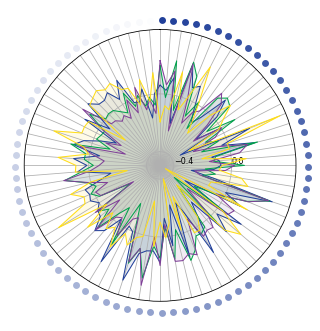

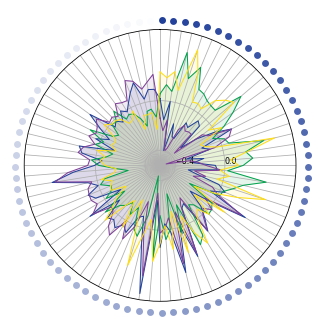

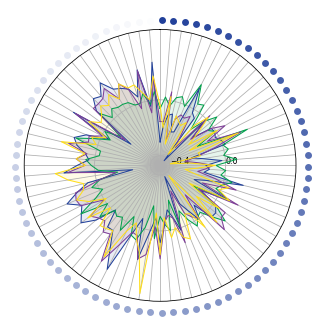

In [87]:
for i in df['Component'].unique():
    spider_plot(df[df['Component'] == i], 'Topic', 'Weight', hue='Condition', colors=condition_colors,
                width=5, height=5, axfontsize=8, tick_labels=['$\\bullet$' for _ in range(topics.shape[0])],
                tick_colors=get_color_gradient(condition_colors['intact'], '#ffffff', topics.shape[0] + 1)[:-1],
                tick_fontsize_scale=3, pad=0 ,legend=False, fname=f'spider_plot_component_{i}')

Average weighting across top $k$ components...

In [88]:
mdf = df.groupby(['Condition', 'Topic']).mean(numeric_only=True).reset_index()
mdf

Condition                                      Topic    Weight
0      intact                ADHD and attention deficits  0.036941
1      intact             Abnormalities in schizophrenia  0.046721
2      intact    Abstract categories and representations -0.064899
3      intact           Action observation and imitation -0.139279
4      intact  Affective valence and feedback processing  0.087437
..        ...                                        ...       ...
315      word                  Tinnitus and hearing loss -0.018760
316      word                  Visual object recognition  0.097330
317      word       Visual perception of motion and form  0.061306
318      word        Working memory and error monitoring  0.061394
319      word      Working memory and executive function  0.103046

[320 rows x 3 columns]

# Figure 5B

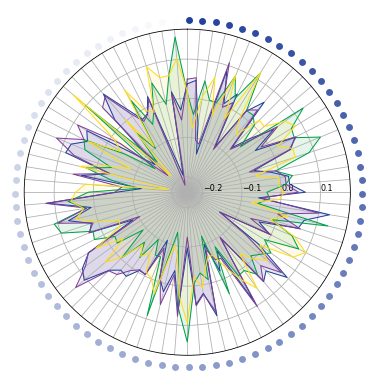

In [89]:
spider_plot(mdf, 'Topic', 'Weight', hue='Condition', colors=condition_colors, 
            tick_labels=['$\\bullet$' for _ in range(topics.shape[0])],
            tick_colors=get_color_gradient(condition_colors['intact'], '#ffffff', topics.shape[0] + 1)[:-1], 
            width=6, height=6, axfontsize=8, tick_fontsize_scale=3, pad=0, legend=False, fname='spider_plot_mean');

What are the top-weighted topics for each component and condition?
  - Row + color: condition
  - Column + shading: component number

In [90]:
def get_term_colors(df):
    colors = pd.DataFrame(index=df.index, columns=df.columns)
    condition_gradients = {c: ['#000000', *get_color_gradient(condition_colors[c], '#ffffff', df.shape[1])[:-1]] for c in conditions}
    for i, row in df.iterrows():
        colors.loc[i] = condition_gradients[row['Condition']]
    return colors

In [91]:
topic_tags = pd.read_csv(os.path.join(neurosynth_dir, 'topics.csv')).drop('Topic Number', axis=1).drop(['Manual Label'], axis=1).rename({'ChatGPT Label': 'Topic Label'}, axis=1)[['Topic Label', 'Cognitive Label']].set_index('Topic Label')
topic_tags

Cognitive Label
Topic Label                                                            
Cognitive control and task performance                Cognitive control
Developmental aging and maturation                                    -
Eye movements and visual attention                            Attention
Facial and voice recognition                         Sensory perception
Social interaction and contextual behavior             Social cognition
...                                                                 ...
Speech and language processing                      Language processing
Network interactions and evidence in human systems                    -
Neuroimaging techniques                                               -
Visual perception of motion and form                 Sensory perception
Emotional processing and regulation                             Emotion

[80 rows x 1 columns]

In [92]:
cognitive_colors = {'Cognitive control': '#9A4035',
                    'Language processing': '#BC427A',
                    'Memory': '#A55BA4',
                    'Emotion': '#6D469C',
                    'Social cognition': '#5358A7',
                    'Spatial cognition': '#457DB5',
                    'Attention': '#54C1AA',
                    'Reward': '#6BBE53',
                    'Sensory perception': '#B7D54F',
                    'Motor control': '#F1E43C',
                    'Resting state': '#BD922F',
                    '-': '#ffffff',
                    'Other': '#ffffff'}

# Figure S2

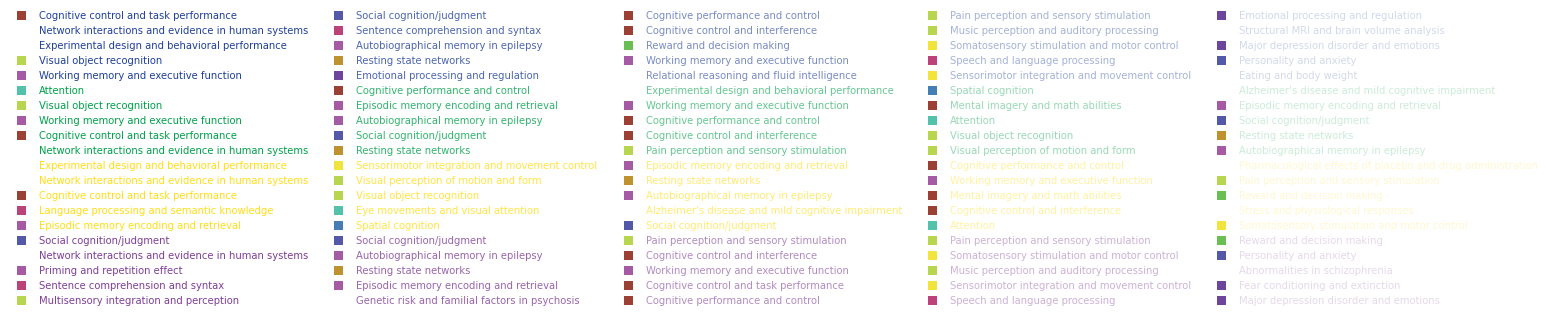

In [93]:
n_terms = 5
top_terms = df.groupby(['Condition', 'Component']).apply(lambda x: x.nlargest(n_terms, 'Weight').sort_values('Weight', ascending=False)).reset_index(drop=True)
top_terms['Topic rank'] = top_terms.groupby(['Condition', 'Component'])['Weight'].rank(ascending=False, method='first').astype(int)

condition_order = {c: i for i, c in enumerate(conditions)}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    top_terms = top_terms.pivot(index=['Condition', 'Topic rank'], columns='Component', values='Topic').reset_index().drop('Topic rank', axis=1)

top_terms['Condition rank'] = top_terms['Condition'].map(condition_order)
top_terms.sort_values('Condition rank', ascending=True, inplace=True)
top_terms.drop('Condition rank', axis=1, inplace=True)

legend_colors = get_term_colors(top_terms).drop('Condition', axis=1)
top_terms.drop('Condition', axis=1, inplace=True)
legend_colors
create_legend([cognitive_colors[topic_tags.loc[t]['Cognitive Label']] for t in top_terms.values.T.ravel()], 
              top_terms.values.T.ravel(), text_colors=legend_colors.values.T.ravel(), width=4, height=2.5, ncol=legend_colors.shape[1], 
              marker='s',
              fname=os.path.join(figdir, 'pca_top_terms'));

Summarize correlations with each category of cognitive process

In [94]:
cog_weights = pd.DataFrame(index=pd.MultiIndex.from_product([conditions, range(1, k + 1)], names=['Condition', 'Component']), columns=list(cognitive_colors.keys())[:-1])
for c in topic_tags['Cognitive Label'].unique():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for i, row in df[df['Topic'].isin(topic_tags[topic_tags['Cognitive Label'] == c].index)].groupby(['Condition', 'Component']).mean().iterrows():
            cog_weights.loc[i, c] = row['Weight']

cog_weights.rename({'-': 'Other'}, axis=1, inplace=True)
cog_weights.reset_index(inplace=True)
#cog_weights['Condition'] = cog_weights['Condition'].apply(lambda x: x.capitalize())
for c in cog_weights.columns[2:]:
    cog_weights[c] = cog_weights[c].astype(float)
cog_weights

Condition  Component  Cognitive control  Language processing    Memory  \
0      intact          1           0.081852             0.045076  0.061732   
1      intact          2          -0.085316             0.079616  0.052317   
2      intact          3           0.182722            -0.141193  0.091675   
3      intact          4          -0.065205            -0.018655 -0.114160   
4      intact          5          -0.152029            -0.112221  0.003741   
5   paragraph          1           0.092413             0.053806  0.060481   
6   paragraph          2           0.071317            -0.002059  0.124074   
7   paragraph          3           0.187665            -0.144464  0.008820   
8   paragraph          4           0.097788             0.013465  0.080731   
9   paragraph          5           0.007517            -0.028450  0.070089   
10       word          1           0.074761             0.066579  0.063558   
11       word          2           0.024426            -0.034149 -0.071358   
12       word          3          -0.063435            -0.180864  0.064462   
13       word          4           0.272169             0.002881  0.108129   
14       word          5          -0.005923            -0.253796 -0.053165   
15       rest          1           0.023114             0.090675  0.051342   
16       rest          2          -0.004082            -0.013156  0.108598   
17       rest          3           0.184935             0.025943  0.008546   
18       rest          4          -0.201441            -0.046535 -0.134097   
19       rest          5          -0.036850            -0.197639 -0.042427   

     Emotion  Social cognition  Spatial cognition  Attention    Reward  \
0  -0.072831         -0.024522           0.121057   0.052294  0.045470   
1   0.129118          0.197695          -0.329809  -0.209787 -0.023978   
2   0.072268          0.052247           0.021834   0.009004  0.215143   
3   0.056486         -0.038067          -0.305047  -0.100819 -0.016810   
4   0.251360          0.107538          -0.164439  -0.132790  0.088834   
5  -0.086891         -0.030349           0.140965   0.067029  0.040168   
6   0.121256          0.165239          -0.165032  -0.131912  0.118101   
7  -0.041674         -0.112739           0.139047   0.106655  0.155696   
8  -0.080243         -0.027938           0.334928   0.152781  0.023541   
9   0.004624          0.049658           0.064233  -0.032604  0.027228   
10 -0.073912         -0.014361           0.098446   0.040629  0.034744   
11 -0.157903         -0.188956           0.326374   0.208095 -0.058548   
12  0.088237          0.120777           0.146102  -0.010874  0.081801   
13 -0.096012         -0.088360           0.261643   0.144925  0.141763   
14  0.123831          0.038378          -0.114169  -0.034151  0.157601   
15 -0.010632          0.070761          -0.039071  -0.014606  0.029065   
16  0.136459          0.196137          -0.213475  -0.178083  0.073841   
17 -0.040421         -0.093560          -0.065880   0.020614  0.089639   
18  0.091754          0.050926          -0.370454  -0.165263 -0.082782   
19  0.190935          0.143512          -0.181091  -0.040022  0.185056   

    Sensory perception  Motor control  Resting state     Other  
0             0.047298       0.018964      -0.000143 -0.089736  
1            -0.095916      -0.278129       0.144455  0.036933  
2            -0.098017      -0.138948       0.140522  0.034025  
3            -0.010894       0.193957      -0.105021  0.020992  
4             0.003277      -0.359215       0.022701  0.088309  
5             0.055712       0.027707      -0.013857 -0.096271  
6            -0.121209      -0.337938       0.182853  0.036469  
7            -0.017804       0.143755      -0.014089  0.005058  
8             0.044146      -0.109903       0.035249 -0.029825  
9            -0.042689      -0.135809       0.135707  0.016896  
10            0.045066       0.004775      -0.006272 -0.093086  
11            0.117505       0

In [95]:
cw_melted = cog_weights.melt(id_vars=['Condition', 'Component'], value_vars=[*list(cognitive_colors.keys())[:-2], 'Other'], var_name='Cognitive Label', value_name='Weight')
cw_melted

Condition  Component    Cognitive Label    Weight
0      intact          1  Cognitive control  0.081852
1      intact          2  Cognitive control -0.085316
2      intact          3  Cognitive control  0.182722
3      intact          4  Cognitive control -0.065205
4      intact          5  Cognitive control -0.152029
..        ...        ...                ...       ...
235      rest          1              Other -0.080512
236      rest          2              Other  0.060295
237      rest          3              Other -0.030870
238      rest          4              Other  0.050989
239      rest          5              Other  0.083913

[240 rows x 4 columns]

In [96]:
def ticks2colors(ticks, a='#000000', b='#000000'):
    for t in ticks:
        mu = (float(t.get_text().replace('−', '-')) + 1) / 2
        t.set_color(mix_colors(a, b, mu))

Create a summarized version of weights by component (i.e., only include a few categories) for use in the main text:
  - Cognitive control
  - Language processing
  - Memory
  - Emotion
  - Social cognition
  - Sensory perception
  - Resting state

In [97]:
cognitive_labels = ['Cognitive control', 'Language processing', 'Memory', 'Emotion', 'Social cognition', 'Spatial cognition', 'Attention', 'Reward', 'Sensory perception', 'Motor control', 'Resting state']
filtered_cognitive_labels = ['Cognitive control', 'Language processing', 'Memory', 'Emotion', 'Social cognition', 'Sensory perception', 'Resting state']
cw_melted_filtered = cw_melted.query('`Cognitive Label` in @filtered_cognitive_labels')
cw_melted_filtered

Condition  Component    Cognitive Label    Weight
0      intact          1  Cognitive control  0.081852
1      intact          2  Cognitive control -0.085316
2      intact          3  Cognitive control  0.182722
3      intact          4  Cognitive control -0.065205
4      intact          5  Cognitive control -0.152029
..        ...        ...                ...       ...
215      rest          1      Resting state  0.036491
216      rest          2      Resting state  0.232282
217      rest          3      Resting state -0.176277
218      rest          4      Resting state  0.063988
219      rest          5      Resting state  0.144119

[140 rows x 4 columns]

# Table S2

In [98]:
cognitive_ranks = pd.read_csv(os.path.join(neurosynth_dir, 'cognitive_processes.csv')).set_index('Cognitive label')

# ignore FutureWarning about using to_latex
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cognitive_ranks.to_latex(os.path.join(figdir, 'cognitive_ranks.tex'))

cognitive_ranks

Rank
Cognitive label          
Cognitive control      10
Language processing     9
Memory                  8
Emotion                 7
Social cognition        6
Spatial cognition       5
Attention               4
Reward                  3
Sensory perception      2
Motor control           1
Resting state           0

In [99]:
cw_melted['Rank'] = cw_melted['Cognitive Label'].map(cognitive_ranks['Rank'])
cw_melted

Condition  Component    Cognitive Label    Weight  Rank
0      intact          1  Cognitive control  0.081852  10.0
1      intact          2  Cognitive control -0.085316  10.0
2      intact          3  Cognitive control  0.182722  10.0
3      intact          4  Cognitive control -0.065205  10.0
4      intact          5  Cognitive control -0.152029  10.0
..        ...        ...                ...       ...   ...
235      rest          1              Other -0.080512   NaN
236      rest          2              Other  0.060295   NaN
237      rest          3              Other -0.030870   NaN
238      rest          4              Other  0.050989   NaN
239      rest          5              Other  0.083913   NaN

[240 rows x 5 columns]

# Figure 6E

Fit a regression line to the weights for each condition: x = Rank; y = Weight.  Then plot the slopes by condition as a bar plot

In [100]:
cw_melted.query('Condition == "intact"')

Condition  Component      Cognitive Label    Weight  Rank
0      intact          1    Cognitive control  0.081852  10.0
1      intact          2    Cognitive control -0.085316  10.0
2      intact          3    Cognitive control  0.182722  10.0
3      intact          4    Cognitive control -0.065205  10.0
4      intact          5    Cognitive control -0.152029  10.0
20     intact          1  Language processing  0.045076   9.0
21     intact          2  Language processing  0.079616   9.0
22     intact          3  Language processing -0.141193   9.0
23     intact          4  Language processing -0.018655   9.0
24     intact          5  Language processing -0.112221   9.0
40     intact          1               Memory  0.061732   8.0
41     intact          2               Memory  0.052317   8.0
42     intact          3               Memory  0.091675   8.0
43     intact          4               Memory -0.114160   8.0
44     intact          5               Memory  0.003741   8.0
60     intact          1              Emotion -0.072831   7.0
61     intact          2              Emotion  0.129118   7.0
62     intact          3              Emotion  0.072268   7.0
63     intact          4              Emotion  0.056486   7.0
64     intact          5              Emotion  0.251360   7.0
80     intact          1     Social cognition -0.024522   6.0
81     intact          2     Social cognition  0.197695   6.0
82     intact          3     Social cognition  0.052247   6.0
83     intact          4     Social cognition -0.038067   6.0
84     intact          5     Social cognition  0.107538   6.0
100    intact          1    Spatial cognition  0.121057   5.0
101    intact          2    Spatial cognition -0.329809   5.0
102    intact          3    Spatial cognition  0.021834   5.0
103    intact          4    Spatial cognition -0.305047   5.0
104    intact          5    Spatial cognition -0.164439   5.0
120    intact          1            Attention  0.052294   4.0
121    intact          2            Attention -0.209787   4.0
122    intact          3            Attention  0.009004   4.0
123    intact          4            Attention -0.100819   4.0
124    intact          5            Attention -0.132790   4.0
140    intact          1               Reward  0.045470   3.0
141    intact          2               Reward -0.023978   3.0
142    intact          3               Reward  0.215143   3.0
143    intact          4               Reward -0.016810   3.0
144    intact          5               Reward  0.088834   3.0
160    intact          1   Sensory perception  0.047298   2.0
161    intact          2   Sensory perception -0.095916   2.0
162    intact          3   Sensory perception -0.098017   2.0
163    intact          4   Sensory perception -0.010894   2.0
164    intact          5   Sensory perception  0.003277   2.0
180    intact          1        Motor control  0.018964   1.0
181    intact          2        Motor control -0.278129   1.0
182    intact          3        Motor control -0.138948   1.0
183    intact          4        Motor control  0.193957   1.0
184    intact          5        Motor control -0.359215   1.0
200    intact          1        Resting state -0.000143   0.0
201    intact          2        Resting state  0.144455   0.0
202    intact          3        Resting state  0.140522   0.0
203    intact          4        Resting state -0.105021   0.0
204    intact          5        Resting state  0.022701   0.0
220    intact          1                Other -0.089736   NaN
221    intact          2                Other  0.036933   NaN
222    intact          3                Other  0.034025   NaN
223    intact          4                Other  0.020992   NaN
224    intact          5                Other  0.088309   NaN

In [101]:
slopes = pd.DataFrame(index=conditions, columns=['Slope'])

for c in conditions:
    c_df = cw_melted.query('Condition == @c').dropna(how='any', axis=0)
    x = c_df['Rank'].values.reshape(-1, 1)
    y = c_df['Weight'].values.reshape(-1, 1)

    regression = LinearRegression().fit(x, y)
    slopes.loc[c, 'Slope'] = float(regression.coef_)

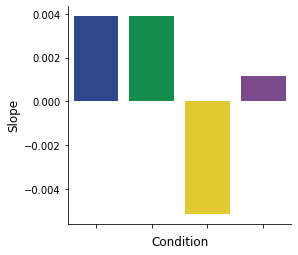

In [102]:
figure = plt.figure(figsize=(4, 4))
sns.barplot(slopes.reset_index().rename({'index': 'Condition'}, axis=1), x='Condition', y='Slope', palette=condition_colors)
sns.despine(top=True, right=True)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Slope', fontsize=12)
plt.gca().set_xticklabels(['' for _ in range(len(conditions))])

plt.savefig(os.path.join(figdir, 'cognitive_process_slopes.pdf'), bbox_inches='tight')

In [103]:
def df2network(df, row_colors, column_colors):
    G = nx.Graph()
    for i, r in df.iterrows():
        G.add_node(i, color=row_colors[i], edge_color='gray')
        for j, v in r.items():
            if not G.has_node(j):
                G.add_node(j, color=column_colors[j], edge_color='k')
            if v > 0:
                G.add_edge(i, j, weight=v)
    return G
    

# Figures 6A and 6B

In [104]:
def reorder_positions(dict, order):
    order = [k for k in order if k in dict]
    return {k: v for k, v in zip(order, dict.values())}

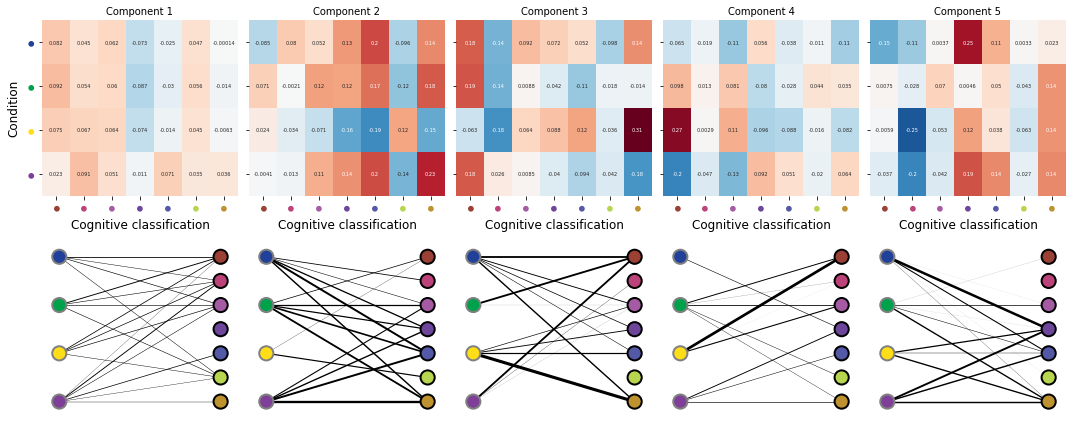

In [105]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, ncols=k, sharex=False, sharey=False)

for i, c in enumerate(cw_melted_filtered['Component'].unique()):
    x = cw_melted_filtered[cw_melted_filtered['Component'] == c].pivot(index='Condition', columns='Cognitive Label', values='Weight').loc[conditions, filtered_cognitive_labels]
    sns.heatmap(x, cmap='RdBu_r', vmin=-0.3, vmax=0.3, ax=ax[0, i], cbar=False, annot=True, annot_kws={'fontsize': 5})

    ax[0, i].set_title(f'Component {c}', fontsize=10)

    if i == 0:
        ax[0, i].set_ylabel('Condition', fontsize=12)
    else:
        ax[0, i].set_ylabel('')

    [t.set_color(condition_colors[t.get_text()]) for t in ax[0, i].get_yticklabels()]

    if i == 0:
        ax[0, i].set_yticklabels(['$\\bullet$' for _ in ax[0, i].get_yticklabels()], fontsize=20)
    else:
        ax[0, i].set_yticklabels(['' for _ in ax[0, i].get_yticklabels()], fontsize=20)
    ax[0, i].set_xlabel('Cognitive classification', fontsize=12)

    [t.set_color(cognitive_colors[t.get_text()]) for t in ax[0, i].get_xticklabels()]
    ax[0, i].set_xticklabels(['$\\bullet$' for _ in ax[0, i].get_xticklabels()], fontsize=20)

    # network plot
    g = df2network(x, condition_colors, cognitive_colors)
    
    pos = reorder_positions(nx.bipartite_layout(g, conditions), [*conditions[::-1], *cognitive_labels[::-1]])
    nx.draw_networkx_edges(g, pos=pos, width=[d['weight']*10 for u, v, d in g.edges(data=True)], ax=ax[1, i])
    nx.draw_networkx_nodes(g, pos=pos, node_color=[n[1]['color'] for n in list(g.nodes(data=True))], edgecolors=[n[1]['edge_color'] for n in list(g.nodes(data=True))], linewidths=2, node_size=200, alpha=1, ax=ax[1, i])
    ax[1, i].axis('off')

plt.tight_layout()
fig.savefig(os.path.join(figdir, 'pca_cognitive_weights_heatmap_summary.pdf'), bbox_inches='tight')
    

# Figure S5A and S5B

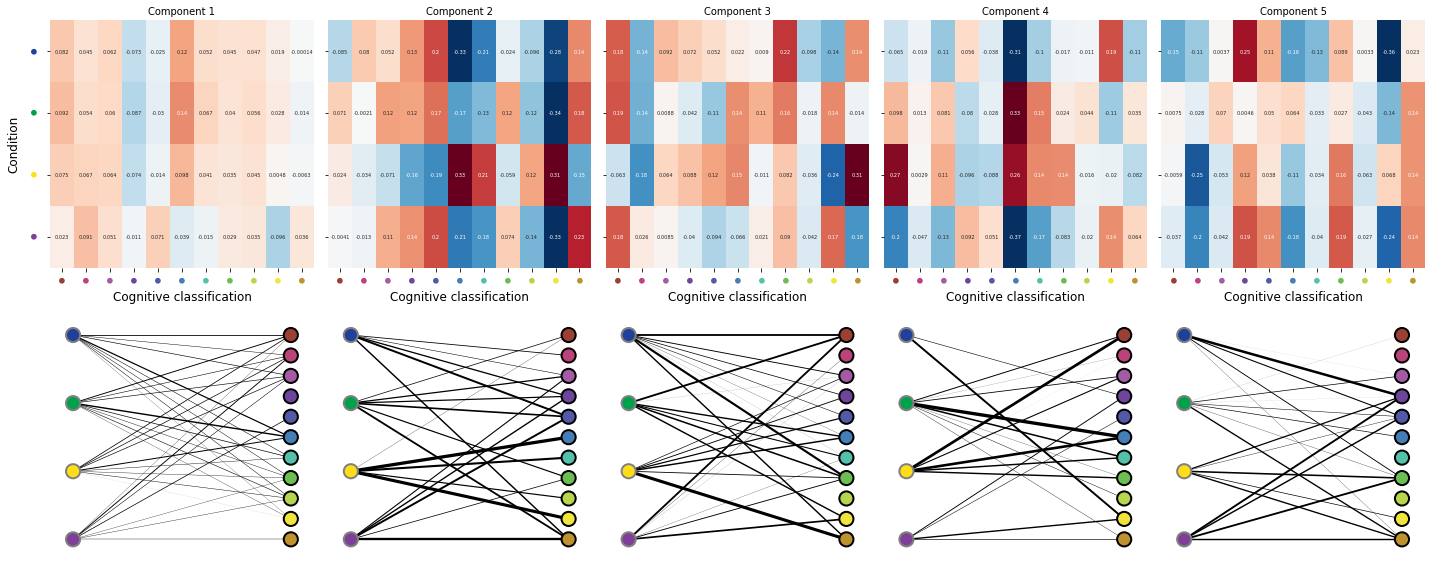

In [106]:
fig, ax = plt.subplots(figsize=(20, 8), nrows=2, ncols=k, sharex=False, sharey=False)

for i, c in enumerate(cw_melted['Component'].unique()):
    x = cw_melted[cw_melted['Component'] == c].pivot(index='Condition', columns='Cognitive Label', values='Weight').loc[conditions, cognitive_labels]
    sns.heatmap(x, cmap='RdBu_r', vmin=-0.3, vmax=0.3, ax=ax[0, i], cbar=False, annot=True, annot_kws={'fontsize': 5})

    ax[0, i].set_title(f'Component {c}', fontsize=10)

    if i == 0:
        ax[0, i].set_ylabel('Condition', fontsize=12)
    else:
        ax[0, i].set_ylabel('')

    [t.set_color(condition_colors[t.get_text()]) for t in ax[0, i].get_yticklabels()]

    if i == 0:
        ax[0, i].set_yticklabels(['$\\bullet$' for _ in ax[0, i].get_yticklabels()], fontsize=20)
    else:
        ax[0, i].set_yticklabels(['' for _ in ax[0, i].get_yticklabels()], fontsize=20)
    ax[0, i].set_xlabel('Cognitive classification', fontsize=12)

    [t.set_color(cognitive_colors[t.get_text()]) for t in ax[0, i].get_xticklabels()]
    ax[0, i].set_xticklabels(['$\\bullet$' for _ in ax[0, i].get_xticklabels()], fontsize=20)

    # network plot
    g = df2network(x, condition_colors, cognitive_colors)
    
    pos = reorder_positions(nx.bipartite_layout(g, conditions), [*conditions[::-1], *cognitive_labels[::-1]])
    nx.draw_networkx_edges(g, pos=pos, width=[d['weight']*10 for u, v, d in g.edges(data=True)], ax=ax[1, i])
    nx.draw_networkx_nodes(g, pos=pos, node_color=[n[1]['color'] for n in list(g.nodes(data=True))], edgecolors=[n[1]['edge_color'] for n in list(g.nodes(data=True))], linewidths=2, node_size=200, alpha=1, ax=ax[1, i])
    ax[1, i].axis('off')

plt.tight_layout()
fig.savefig(os.path.join(figdir, 'pca_cognitive_weights_heatmap_full.pdf'), bbox_inches='tight')

Pairwise correlations between conditions, by component

# Figures S5B and S5C

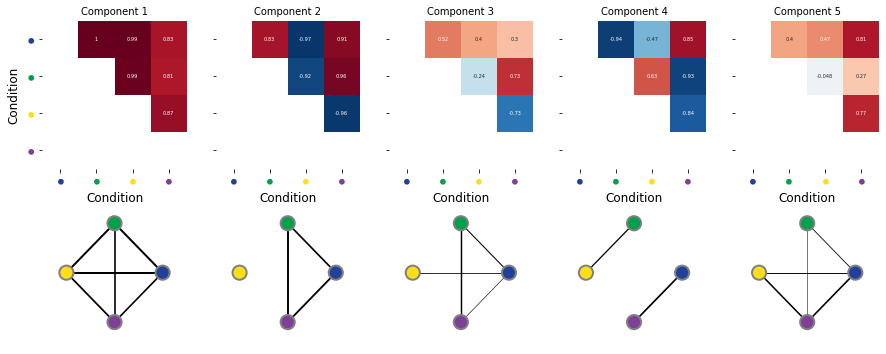

In [107]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, ncols=k, sharex=False, sharey=False)

for component in range(1, k + 1):
    x = pd.DataFrame(index=conditions, columns=conditions, dtype=float)
    for i, c in enumerate(conditions):
        a = df.query('Condition == @c & Component == @component')['Weight'].values
        for d in conditions[(i + 1):]:
            b = df.query('Condition == @d & Component == @component')['Weight'].values
            x.loc[c, d] = np.corrcoef(a, b)[0, 1]

    sns.heatmap(x, cmap='RdBu_r', vmin=-1, vmax=1, ax=ax[0, component - 1], cbar=False, annot=True, annot_kws={'fontsize': 5})
    ax[0, component - 1].set_title(f'Component {component}', fontsize=10)

    if component == 1:
        ax[0, component - 1].set_ylabel('Condition', fontsize=12)
        [t.set_color(condition_colors[t.get_text()]) for t in ax[0, component - 1].get_yticklabels()]
        ax[0, component - 1].set_yticklabels(['$\\bullet$' for _ in ax[0, component - 1].get_yticklabels()], fontsize=20)
    else:
        ax[0, component - 1].set_ylabel('')
        ax[0, component - 1].set_yticklabels(['' for _ in ax[0, component - 1].get_yticklabels()], fontsize=20)
    
    ax[0, component - 1].set_xlabel('Condition', fontsize=12)

    [t.set_color(condition_colors[t.get_text()]) for t in ax.ravel()[component - 1].get_xticklabels()]
    ax[0, component - 1].set_xticklabels(['$\\bullet$' for _ in ax[0, component - 1].get_xticklabels()], fontsize=20)

    # network plot
    g = df2network(x, condition_colors, condition_colors)
    
    pos = nx.circular_layout(g)
    nx.draw_networkx_edges(g, pos=pos, width=[d['weight'] * 2 for u, v, d in g.edges(data=True)], ax=ax[1, component - 1])
    nx.draw_networkx_nodes(g, pos=pos, node_color=[n[1]['color'] for n in list(g.nodes(data=True))], edgecolors=[n[1]['edge_color'] for n in list(g.nodes(data=True))], linewidths=2, node_size=200, alpha=1, ax=ax[1, component - 1])
    ax[1, component - 1].set_xlim([-1.5, 1.5])
    ax[1, component - 1].set_ylim([-1.5, 1.5])
    ax[1, component - 1].axis('off')

fig.savefig(os.path.join(figdir, 'pca_cognitive_weights_correlations.pdf'), bbox_inches='tight')

    


# Figures 6C and 6D

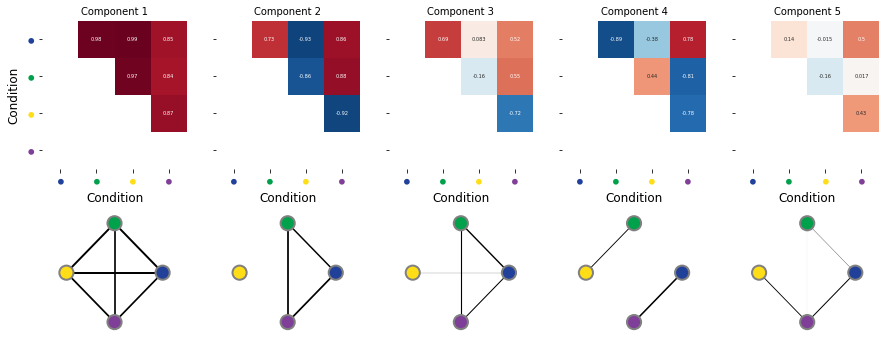

In [108]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=2, ncols=k, sharex=False, sharey=False)

for component in range(1, k + 1):
    x = pd.DataFrame(index=conditions, columns=conditions, dtype=float)
    for i, c in enumerate(conditions):
        a = cmu_components[c][component - 1]['Y']
        for d in conditions[(i + 1):]:
            b = cmu_components[d][component - 1]['Y']
            x.loc[c, d] = np.corrcoef(a, b)[0, 1]

    sns.heatmap(x, cmap='RdBu_r', vmin=-1, vmax=1, ax=ax[0, component - 1], cbar=False, annot=True, annot_kws={'fontsize': 5})
    ax[0, component - 1].set_title(f'Component {component}', fontsize=10)

    if component == 1:
        ax[0, component - 1].set_ylabel('Condition', fontsize=12)
        [t.set_color(condition_colors[t.get_text()]) for t in ax[0, component - 1].get_yticklabels()]
        ax[0, component - 1].set_yticklabels(['$\\bullet$' for _ in ax[0, component - 1].get_yticklabels()], fontsize=20)
    else:
        ax[0, component - 1].set_ylabel('')
        ax[0, component - 1].set_yticklabels(['' for _ in ax[0, component - 1].get_yticklabels()], fontsize=20)
    
    ax[0, component - 1].set_xlabel('Condition', fontsize=12)

    [t.set_color(condition_colors[t.get_text()]) for t in ax.ravel()[component - 1].get_xticklabels()]
    ax[0, component - 1].set_xticklabels(['$\\bullet$' for _ in ax[0, component - 1].get_xticklabels()], fontsize=20)

    # network plot
    g = df2network(x, condition_colors, condition_colors)
    
    pos = nx.circular_layout(g)
    nx.draw_networkx_edges(g, pos=pos, width=[d['weight'] * 2 for u, v, d in g.edges(data=True)], ax=ax[1, component - 1])
    nx.draw_networkx_nodes(g, pos=pos, node_color=[n[1]['color'] for n in list(g.nodes(data=True))], edgecolors=[n[1]['edge_color'] for n in list(g.nodes(data=True))], linewidths=2, node_size=200, alpha=1, ax=ax[1, component - 1])
    ax[1, component - 1].set_xlim([-1.5, 1.5])
    ax[1, component - 1].set_ylim([-1.5, 1.5])
    ax[1, component - 1].axis('off')

fig.savefig(os.path.join(figdir, 'pca_brain_correlations.pdf'), bbox_inches='tight')

for each combination of condition pairs:
- Each condition gets a dot; color as in the neurosynth figure
- X-axis different in topic weight between intact and word conditions
- Y-axis: difference in topic weight between paragraph and rest

Panels could either show different combinations of conditions or different components
Some dots could have text labels to highlight notable observations

In [109]:
diffs = df.query('Condition == "intact"')[['Component', 'Topic']].copy()
diffs

Component                                              Topic
0           1             Cognitive control and task performance
76          1  Network interactions and evidence in human sys...
6           1     Experimental design and behavioral performance
67          1                          Visual object recognition
25          1              Working memory and executive function
..        ...                                                ...
397         5                            Neuroimaging techniques
357         5           Neurodegenerative diseases and disorders
341         5                     Abnormalities in schizophrenia
390         5                   Lesion and stroke rehabilitation
359         5           Structural MRI and brain volume analysis

[400 rows x 2 columns]

In [110]:
diffs['Intact - word'] = df[df['Condition'] == 'intact']['Weight'].values - df[df['Condition'] == 'word']['Weight'].values
diffs['Paragraph - rest'] = df[df['Condition'] == 'paragraph']['Weight'].values - df[df['Condition'] == 'rest']['Weight'].values
diffs['Intact - paragraph'] = df[df['Condition'] == 'intact']['Weight'].values - df[df['Condition'] == 'paragraph']['Weight'].values
diffs['Word - rest'] = df[df['Condition'] == 'word']['Weight'].values - df[df['Condition'] == 'rest']['Weight'].values
diffs['Intact - rest'] = df[df['Condition'] == 'intact']['Weight'].values - df[df['Condition'] == 'rest']['Weight'].values
diffs['Paragraph - word'] = df[df['Condition'] == 'paragraph']['Weight'].values - df[df['Condition'] == 'word']['Weight'].values
diffs['Topic rank'] = np.tile(range(1, topics.shape[0] + 1), len(diffs['Component'].unique()))
diffs

Component                                              Topic  \
0           1             Cognitive control and task performance   
76          1  Network interactions and evidence in human sys...   
6           1     Experimental design and behavioral performance   
67          1                          Visual object recognition   
25          1              Working memory and executive function   
..        ...                                                ...   
397         5                            Neuroimaging techniques   
357         5           Neurodegenerative diseases and disorders   
341         5                     Abnormalities in schizophrenia   
390         5                   Lesion and stroke rehabilitation   
359         5           Structural MRI and brain volume analysis   

     Intact - word  Paragraph - rest  Intact - paragraph  Word - rest  \
0         0.007557          0.109388           -0.013786     0.088045   
76       -0.014201          0.009989           -0.009565     0.014625   
6         0.013813          0.078338           -0.010586     0.053939   
67        0.021630          0.120302           -0.024370     0.074302   
25        0.009402          0.150785           -0.019717     0.121666   
..             ...               ...                 ...          ...   
397      -0.008670         -0.116577            0.123673     0.015766   
357      -0.090630          0.037478            0.050624     0.178731   
341       0.170927         -0.168679            0.173569    -0.166037   
390      -0.047472          0.058515           -0.011950     0.094038   
359       0.099076         -0.101096            0.211385     0.011212   

     Intact - rest  Paragraph - word  Topic rank  
0         0.095602          0.021343           1  
76        0.000424         -0.004636           2  
6         0.067752          0.024399           3  
67        0.095931          0.046000           4  
25        0.131069          0.029119           5  
..             ...               ...         ...  
397       0.007096         -0.132343          76  
357       0.088101         -0.141253          77  
341       0.004890         -0.002643          78  
390       0.046565         -0.035522          79  
359       0.110289         -0.112309          80  

[400 rows x 9 columns]

In [111]:
def pretty_scatter(df, xcol, ycol, hue, palette='viridis', legend=False, fname=None, s=100, xlim=[-1, 1], ylim=[-1, 1], fontsize=12, width=4, height=3, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(width, height))        
        ax = plt.gca()
    else:
        fig = ax.get_figure()
    
    sns.scatterplot(data=df, x=xcol, y=ycol, s=s, hue=hue, palette=palette, legend=legend, ax=ax, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel(ax.get_xlabel().capitalize(), fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel().capitalize(), fontsize=fontsize)
    
    sns.despine(right=True, top=True)
    
    corr_results = pearsonr(df[xcol].values, df[ycol].values)
    if corr_results.pvalue < 0.001:
        p_string = f'$p$ < 0.001'
    else:
        p_string = f'$p$ = {corr_results.pvalue:.3f}'
    
    result = f'$r$ = {corr_results.statistic:.3f}\n{p_string}'
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=result, markerfacecolor='w', markersize=1)]
    ax.legend(handles=legend_elements, loc='best', fontsize=10, frameon=False)

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')

    return fig

In [112]:
groups = []
for i, (cond, g) in enumerate(df.groupby('Condition')):
    g.drop('Condition', axis=1, inplace=True)
    g.rename(columns={'Weight': cond}, inplace=True)
    g.reset_index(drop=True, inplace=True)

    if i > 0:
        g.drop(['Component', 'Topic'], axis=1, inplace=True)

    groups.append(g)

cond_df = pd.concat(groups, axis=1)
cond_df['Topic rank'] = np.tile(range(1, topics.shape[0] + 1), len(cond_df['Component'].unique()))

In [113]:
cond_df

Component                                              Topic    intact  \
0           1             Cognitive control and task performance  0.247097   
1           1  Network interactions and evidence in human sys...  0.244634   
2           1     Experimental design and behavioral performance  0.176990   
3           1                          Visual object recognition  0.174161   
4           1              Working memory and executive function  0.168216   
..        ...                                                ...       ...   
395         5                            Neuroimaging techniques  0.122220   
396         5           Neurodegenerative diseases and disorders  0.045943   
397         5                     Abnormalities in schizophrenia  0.233898   
398         5                   Lesion and stroke rehabilitation -0.041562   
399         5           Structural MRI and brain volume analysis  0.271921   

     paragraph      rest      word  Topic rank  
0     0.260882  0.151495  0.239539           1  
1     0.254199  0.244210  0.258835           2  
2     0.187576  0.109238  0.163178           3  
3     0.198532  0.078230  0.152532           4  
4     0.187932  0.037147  0.158813           5  
..         ...       ...       ...         ...  
395  -0.001453  0.115124  0.130890          76  
396  -0.004680 -0.042158  0.136573          77  
397   0.060328  0.229008  0.062971          78  
398  -0.029612 -0.088127  0.005910          79  
399   0.060536  0.161632  0.172845          80  

[400 rows x 7 columns]

# Figure S4

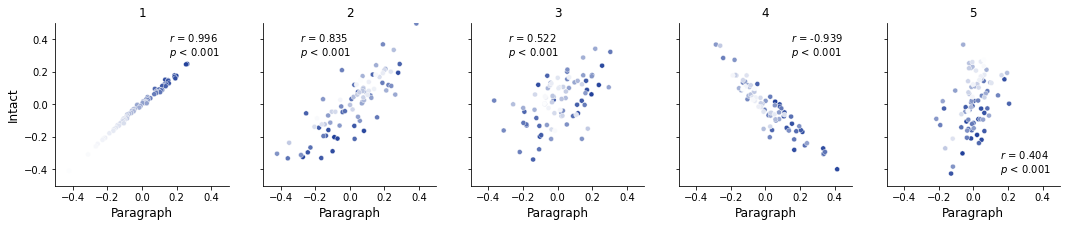

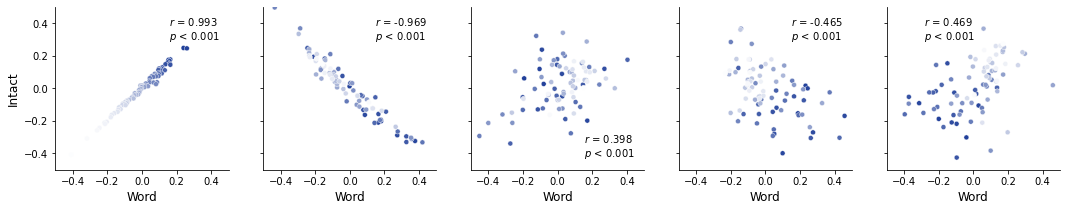

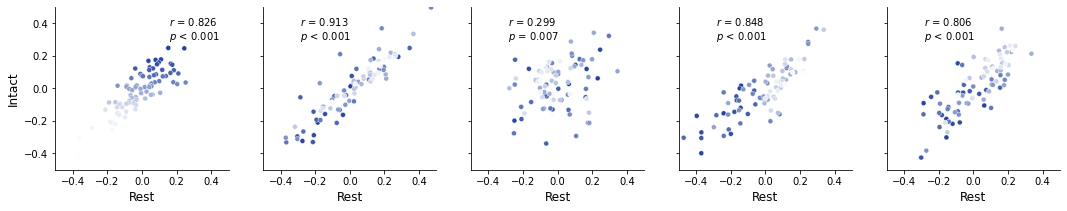

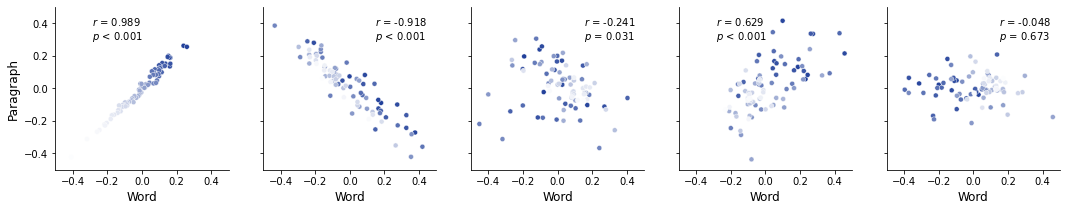

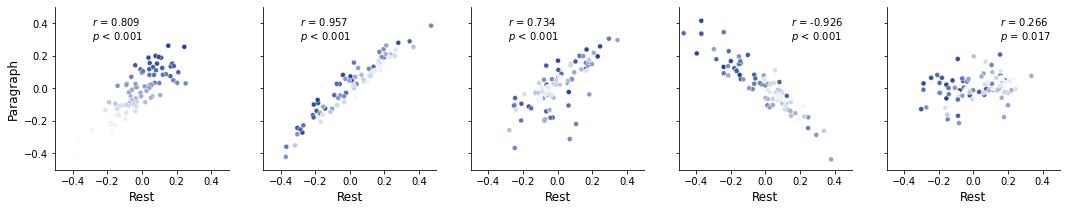

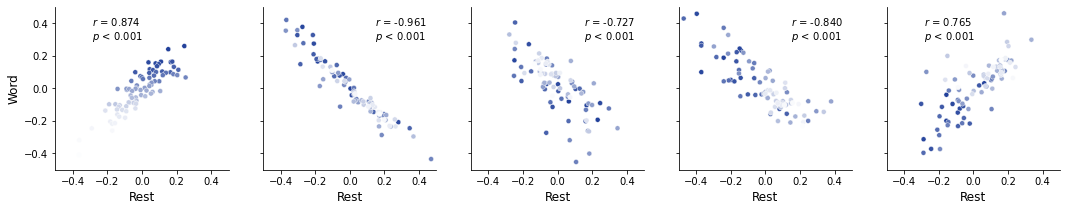

In [114]:
title = True
for x, c1 in enumerate(conditions):
    for c2 in conditions[(x + 1):]:
        fig, ax = plt.subplots(1, 5, figsize=(18, 3), sharex=True, sharey=True)
        
        for i in df['Component'].unique():
            pretty_scatter(cond_df[cond_df['Component'] == i], c2, c1, 'Topic rank',
                           palette=get_color_gradient(condition_colors['intact'], '#ffffff', topics.shape[0] + 1)[:-1],
                           legend=False, s=25, fontsize=12, width=4, height=3, xlim=[-0.5, 0.5], ylim=[-0.5, 0.5],
                           ax=ax[i - 1]);        
            if title:
                ax[i - 1].set_title(f'{i}', fontsize=12)
        title = False
        fig.savefig(os.path.join(figdir, f'topic_scatter_{c1}_{c2}.pdf'), bbox_inches='tight')

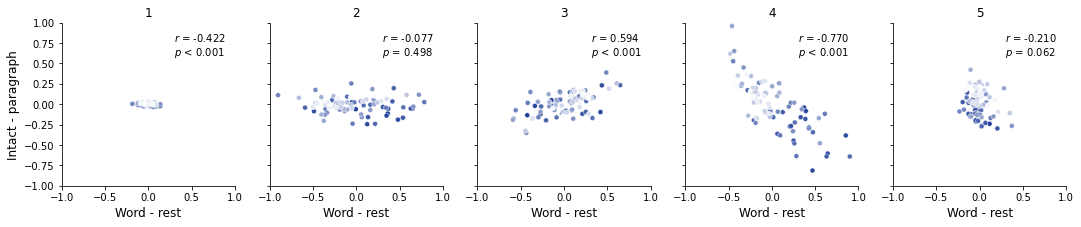

In [115]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3), sharex=True, sharey=True)
for i in df['Component'].unique():
    pretty_scatter(diffs.query('Component == @i'), 'Word - rest', 'Intact - paragraph', 'Topic rank',
                   palette=get_color_gradient(condition_colors['intact'], '#ffffff', topics.shape[0] + 1)[:-1],
                   legend=False, s=25, fontsize=12, width=3.7, height=3, ax=ax[i - 1]);
    ax[i - 1].set_title(f'{i}', fontsize=12)
fig.savefig(os.path.join(figdir, 'topic_diffs_intact_paragraph.pdf'), bbox_inches='tight')

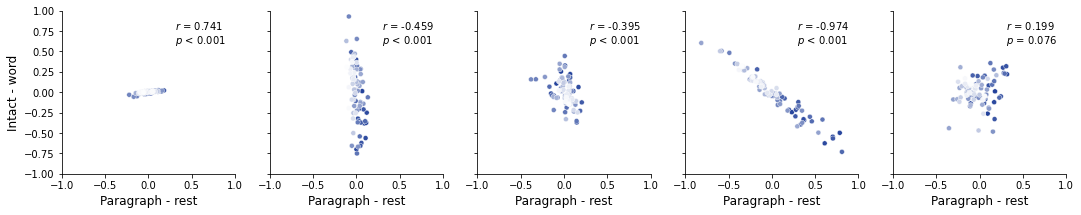

In [116]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3), sharex=True, sharey=True)
for i in df['Component'].unique():
    pretty_scatter(diffs.query('Component == @i'), 'Paragraph - rest', 'Intact - word', 'Topic rank',
                   palette=get_color_gradient(condition_colors['intact'], '#ffffff', topics.shape[0] + 1)[:-1],
                   legend=False, s=25, fontsize=12, width=3.7, height=3, ax=ax[i - 1]);
fig.savefig(os.path.join(figdir, 'topic_diffs_intact_word.pdf'), bbox_inches='tight')


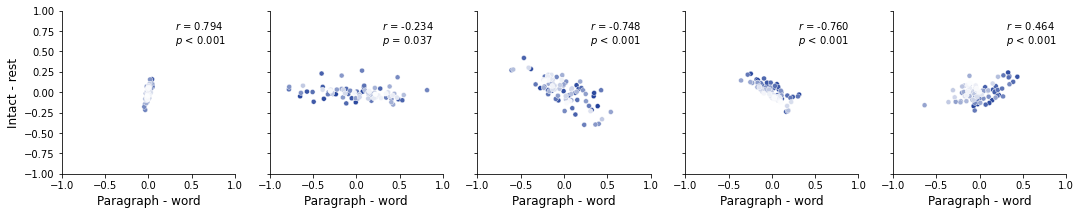

In [117]:
fig, ax = plt.subplots(1, 5, figsize=(18, 3), sharex=True, sharey=True)
for i in df['Component'].unique():
    pretty_scatter(diffs.query('Component == @i'), 'Paragraph - word', 'Intact - rest', 'Topic rank',
                   palette=get_color_gradient(condition_colors['intact'], '#ffffff', topics.shape[0] + 1)[:-1],
                   legend=False, s=25, fontsize=12, width=3.7, height=3, ax=ax[i - 1]);
fig.savefig(os.path.join(figdir, 'topic_diffs_intact_rest.pdf'), bbox_inches='tight')